In [1]:
from pyspark.sql import SparkSession
from replay.session_handler import State

SPARK_LOCAL_DIR = '/data/home/anthony/tmp'
RESULT_DIR = '../bin'

NUM_JOBS = 8

spark = SparkSession.builder\
    .appName('simulator')\
    .master(f'local[{NUM_JOBS}]')\
    .config('spark.sql.shuffle.partitions', f'{NUM_JOBS}')\
    .config('spark.default.parallelism', f'{NUM_JOBS}')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.sql.autoBroadcastJoinThreshold', '-1')\
    .config('spark.driver.memory', '256g')\
    .config('spark.local.dir', SPARK_LOCAL_DIR)\
    .getOrCreate()

State(spark)

/data/home/anthony/.conda/envs/simulator-3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
22/10/11 11:36:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/11 11:36:50 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [2]:
import time
import pandas as pd
import numpy as np
from simulator.utils.convert import pandas_to_spark

import warnings
warnings.filterwarnings("ignore")

NUM_TRAIN_SAMPLES = [10, 100, 1000, 10000, 100000]
NUM_DIMS = 300
dfs = {}

for n in NUM_TRAIN_SAMPLES:
    dfs[n] = pandas_to_spark(
        pd.DataFrame(
            data=np.random.normal(0, 1, size=(n, NUM_DIMS)),
            columns=[f'attr_{i}' for i in range(NUM_DIMS)]
        )
    ).cache()
    dfs[n].count()

def measure_fit_time(generator, df, save_model_file=None):
    result = None
    
    try:
        start = time.time()
        generator.fit(df)
        result = time.time() - start

        if save_model_file is not None:
            generator.save_model(save_model_file)
    except:
        pass

    return result

22/10/11 11:37:16 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
22/10/11 11:37:46 WARN TaskSetManager: Stage 6 contains a task of very large size (2707 KiB). The maximum recommended task size is 1000 KiB.
22/10/11 11:40:43 WARN TaskSetManager: Stage 8 contains a task of very large size (32445 KiB). The maximum recommended task size is 1000 KiB.


In [ ]:
from simulator.modules import SDVDataGenerator
from simulator.utils import save, load

generators = []

for name in ['copulagan', 'ctgan', 'gaussiancopula', 'tvae']:
    generators.append(
        SDVDataGenerator(
            label=name,
            id_column_name='id',
            model_name=name,
            parallelization_level=NUM_JOBS,
            device_name='cuda:1'
        )
    )

fit_time = {}
for g in generators:
    fit_time[g.getLabel()] = []
    for n in NUM_TRAIN_SAMPLES:
        print(f'Fitting {g.getLabel()} on {n} samples')
        save_file = None if n != NUM_TRAIN_SAMPLES[-1] else f'{RESULT_DIR}/genscale_{g.getLabel()}_{n}.pkl'
        fit_time[g.getLabel()].append(measure_fit_time(g, dfs[n], save_file))

save(fit_time, f'{RESULT_DIR}/generators_fit_time.pkl')

Fitting copulagan on 10 samples
Fitting copulagan on 100 samples
Fitting copulagan on 1000 samples
Fitting copulagan on 10000 samples


22/10/11 11:47:15 WARN TaskSetManager: Stage 13 contains a task of very large size (2707 KiB). The maximum recommended task size is 1000 KiB.


Fitting copulagan on 100000 samples


22/10/11 12:22:48 WARN TaskSetManager: Stage 14 contains a task of very large size (32445 KiB). The maximum recommended task size is 1000 KiB.


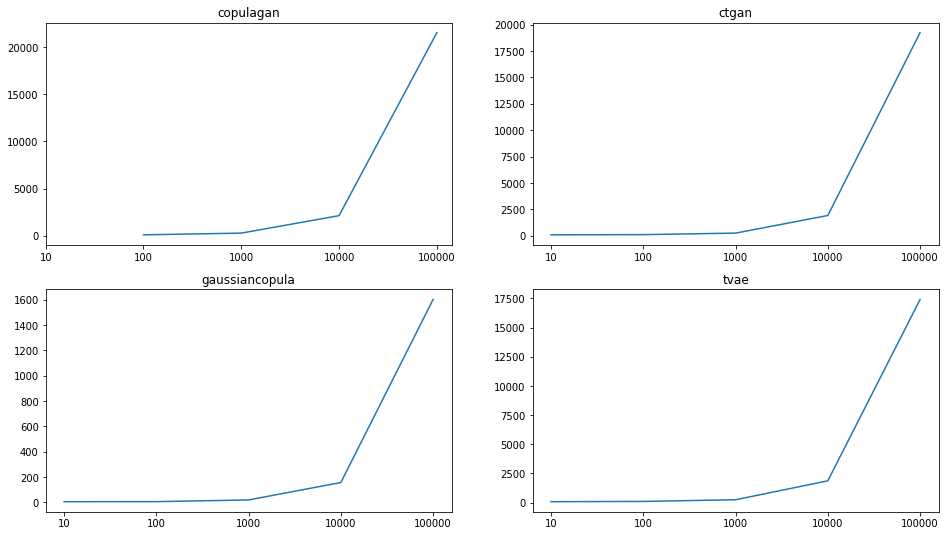

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

fit_time = load(f'{RESULT_DIR}/generators_fit_time.pkl')

fig, ax = plt.subplots(2, 2, figsize=(16, 9))

for i, (name, t) in enumerate(fit_time.items()):
    row = i // 2
    col = i % 2
    
    ax[row, col].plot(t)
    ax[row, col].set_title(name)
    ax[row, col].set_xticks(np.arange(len(t)), np.array(NUM_TRAIN_SAMPLES))